<a href="https://colab.research.google.com/github/Arif111866/Deep-Learning-AI/blob/main/Assignment_13/DNN_assignment_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional GAN for CelebA Face Generation with Hair Length Conditioning
# Description: CGAN implementation for CelebA dataset with hair length detection

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
import glob


In [31]:


print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [32]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
path1=path
print("Dataset path -----:", path)
import os
print(os.listdir(path))

Dataset path -----: /kaggle/input/celeba-dataset
['list_landmarks_align_celeba.csv', 'img_align_celeba', 'list_eval_partition.csv', 'list_attr_celeba.csv', 'list_bbox_celeba.csv']


In [33]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Cell 2: Configuration for CelebA
class Config:
    # Image parameters
    IMG_HEIGHT = 64
    IMG_WIDTH = 64
    IMG_CHANNELS = 3

    # Model parameters
    LATENT_DIM = 128
    NUM_CLASSES = 2   # 0: short hair, 1: long hair
    EMBEDDING_DIM = 64

    # Training parameters
    BATCH_SIZE = 64
    EPOCHS = 350
    LEARNING_RATE_G = 0.0002
    LEARNING_RATE_D = 0.0002
    BETA_1 = 0.5
    BETA_2 = 0.999

    # Training stability
    # Training stability
    LABEL_SMOOTHING = 0.1

    # Paths - Update these to match your CelebA dataset location
    CELEBA_PATH = path1  # Update this path
    IMG_DIR = "img_align_celeba/img_align_celeba/"  # CelebA images folder
    ATTR_FILE = "list_attr_celeba.csv"  # Attributes file

    CHECKPOINT_PATH = "checkpoints/"
    OUTPUT_PATH = "output/"

config = Config()

In [34]:

# Create directories
os.makedirs(config.CHECKPOINT_PATH, exist_ok=True)
os.makedirs(config.OUTPUT_PATH, exist_ok=True)

# Cell 3: CelebA Data Loading and Processing
def load_celeba_data(max_samples=1000):
    """Load CelebA dataset with hair length labeling"""

    # Load attributes file
    attr_path = os.path.join(config.CELEBA_PATH, config.ATTR_FILE)
    if os.path.exists(attr_path):
        print("Loading CelebA attributes...")
        df = pd.read_csv(attr_path)
        print(f"Loaded attributes for {len(df)} images")
        print("Available attributes:", df.columns.tolist())
    else:
        print(f"Attributes file not found at {attr_path}")
        print("Available files in dataset:")
        for root, dirs, files in os.walk(config.CELEBA_PATH):
            for file in files[:10]:  # Show first 10 files
                print(f"  {os.path.join(root, file)}")
        return None, None

    # Image directory
    img_dir = os.path.join(config.CELEBA_PATH, config.IMG_DIR)
    if not os.path.exists(img_dir):
        # Try alternative paths
        img_dir = os.path.join(config.CELEBA_PATH, "img_align_celeba/")
        if not os.path.exists(img_dir):
            img_dir = config.CELEBA_PATH

    print(f"Looking for images in: {img_dir}")

    # Get list of image files
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        image_files.extend(glob.glob(os.path.join(img_dir, ext)))

    if not image_files:
        print("No image files found! Checking subdirectories...")
        for root, dirs, files in os.walk(config.CELEBA_PATH):
            jpg_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            if jpg_files:
                print(f"Found {len(jpg_files)} images in {root}")
                image_files = [os.path.join(root, f) for f in jpg_files]
                break

    print(f"Found {len(image_files)} total images")

    # Limit samples for memory management
    if len(image_files) > max_samples:
        image_files = image_files[:max_samples]
        print(f"Limited to {max_samples} samples for training")

    # Load images and create hair length labels
    images = []
    labels = []

    print("Loading and processing images...")

    for i, img_path in enumerate(image_files):
        if i % 1000 == 0:
            print(f"Processed {i}/{len(image_files)} images")

        try:
            # Load image
            img = Image.open(img_path)
            img = img.convert('RGB')
            img = img.resize((config.IMG_WIDTH, config.IMG_HEIGHT))
            img_array = np.array(img) / 255.0  # Normalize to [0,1]

            # Get filename for attribute lookup
            filename = os.path.basename(img_path)

            # Determine hair length based on CelebA attributes
            hair_label = determine_hair_length(df, filename)

            images.append(img_array)
            labels.append(hair_label)

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

    if not images:
        print("No images loaded successfully!")
        return None, None

    print(f"Successfully loaded {len(images)} images")
    images = np.array(images)
    labels = np.array(labels)

    print(f"Dataset shape: {images.shape}")
    print(f"Short hair samples: {np.sum(labels == 0)}")
    print(f"Long hair samples: {np.sum(labels == 1)}")

    return images, labels


In [35]:

def determine_hair_length(df, filename):
    """Determine hair length based on CelebA attributes"""
    try:
        # Find row for this image
        if filename in df['image_id'].values:
            row = df[df['image_id'] == filename].iloc[0]
        elif filename in df.index:
            row = df.loc[filename]
        else:
            # Default to random if not found
            return np.random.randint(0, 2)

        # Use CelebA attributes to determine hair length
        # CelebA uses -1 for absent, 1 for present

        # Check for hair-related attributes
        hair_indicators = {
            'Bangs': 0,  # Often indicates shorter styles
            'Wavy_Hair': 1,  # Often longer
            'Straight_Hair': 0.5,  # Can be either
            'Black_Hair': 0.5,
            'Blond_Hair': 0.5,
            'Brown_Hair': 0.5,
            'Gray_Hair': 0.3,  # Often shorter
        }

        # Calculate hair length score
        hair_score = 0
        count = 0

        for attr, weight in hair_indicators.items():
            if attr in row.index:
                if row[attr] == 1:  # Attribute is present
                    hair_score += weight
                    count += 1

        # Additional logic based on other attributes
        if 'Young' in row.index and row['Young'] == 1:
            hair_score += 0.3  # Young people often have longer hair

        if 'Male' in row.index and row['Male'] == 1:
            hair_score -= 0.4  # Males often have shorter hair

        # Normalize and decide
        if count > 0:
            hair_score /= count

        # Add some randomness to create variety
        hair_score += np.random.uniform(-0.2, 0.2)

        # Convert to binary label
        return 1 if hair_score > 0.4 else 0

    except Exception as e:
        # Default to random if any error
        return np.random.randint(0, 2)

def preprocess_images(images):
    """Normalize images to [-1, 1] range for GAN training"""
    return (images.astype(np.float32) * 2.0) - 1.0

def postprocess_images(images):
    """Convert images back to [0, 1] range for display"""
    if tf.is_tensor(images):
        images = tf.clip_by_value((images + 1.0) / 2.0, 0.0, 1.0)
        return images.numpy()
    else:
        return np.clip((images + 1.0) / 2.0, 0.0, 1.0)

# Load CelebA data
print("Loading CelebA dataset...")
X, y = load_celeba_data(max_samples=1500)  # Adjust based on your memory

if X is None:
    print("Failed to load CelebA data. Please check your paths and try again.")
    # You can uncomment the line below if you want to continue with synthetic data
    # X, y = generate_synthetic_celeba_data(5000)
else:
    X = preprocess_images(X)
    print("CelebA data loaded successfully!")

# Cell 4: Enhanced Generator for Realistic Faces
def build_celeba_generator(latent_dim, num_classes, embedding_dim):
    """Generator optimized for CelebA-style face generation"""

    # Noise input
    noise = layers.Input(shape=(latent_dim,), name='noise_input')

    # Label input with embedding
    label = layers.Input(shape=(1,), name='label_input', dtype='int32')
    label_embedding = layers.Embedding(num_classes, embedding_dim)(label)
    label_embedding = layers.Flatten()(label_embedding)

    # Combine noise and label
    combined = layers.Concatenate()([noise, label_embedding])

    # Initial dense layer
    x = layers.Dense(4 * 4 * 1024, use_bias=False)(combined)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Reshape((4, 4, 1024))(x)

    # Upsampling blocks - 4x4 -> 8x8
    x = layers.Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 8x8 -> 16x16
    x = layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 16x16 -> 32x32
    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 32x32 -> 64x64
    x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Final output layer
    x = layers.Conv2D(3, (3, 3), padding='same', activation='tanh')(x)

    model = keras.Model([noise, label], x, name='celeba_generator')
    return model


Loading CelebA dataset...
Loading CelebA attributes...
Loaded attributes for 202599 images
Available attributes: ['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
Looking for images in: /kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/
Found 202599 total images
Limited to 1500 samples for training
Loading and processing images...
Processed 0/1500 images
Processed 1000/1500 images
Successfully loaded 1500 images
Dataset shape: (1500, 64

In [36]:

# Cell 5: Enhanced Discriminator for CelebA
def build_celeba_discriminator(img_shape, num_classes, embedding_dim):
    """Discriminator optimized for CelebA-style face discrimination"""

    # Image input
    img = layers.Input(shape=img_shape, name='image_input')

    # Label input with embedding
    label = layers.Input(shape=(1,), name='label_input', dtype='int32')
    label_embedding = layers.Embedding(num_classes, embedding_dim)(label)
    label_embedding = layers.Dense(np.prod(img_shape))(label_embedding)
    label_embedding = layers.Reshape(img_shape)(label_embedding)

    # Concatenate image and label
    x = layers.Concatenate()([img, label_embedding])

    # Convolution blocks
    x = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)

    model = keras.Model([img, label], x, name='celeba_discriminator')
    return model


In [37]:

# Build models for CelebA
if X is not None:
    generator = build_celeba_generator(config.LATENT_DIM, config.NUM_CLASSES, config.EMBEDDING_DIM)
    discriminator = build_celeba_discriminator(
        (config.IMG_HEIGHT, config.IMG_WIDTH, config.IMG_CHANNELS),
        config.NUM_CLASSES,
        config.EMBEDDING_DIM
    )

    print("CelebA Generator summary:")
    generator.summary()
    print("\nCelebA Discriminator summary:")
    discriminator.summary()

# Cell 6: Loss Functions and Optimizers
def discriminator_loss(real_output, fake_output):
    """Binary crossentropy loss with label smoothing"""
    real_labels = tf.ones_like(real_output) * (1.0 - config.LABEL_SMOOTHING)
    fake_labels = tf.zeros_like(fake_output)

    real_loss = tf.keras.losses.binary_crossentropy(real_labels, real_output, from_logits=True)
    fake_loss = tf.keras.losses.binary_crossentropy(fake_labels, fake_output, from_logits=True)

    total_loss = tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss)
    return total_loss

def generator_loss(fake_output):
    """Generator tries to fool discriminator"""
    fake_labels = tf.ones_like(fake_output)
    gen_loss = tf.keras.losses.binary_crossentropy(fake_labels, fake_output, from_logits=True)
    return tf.reduce_mean(gen_loss)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=config.LEARNING_RATE_G,
    beta_1=config.BETA_1,
    beta_2=config.BETA_2
)
discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=config.LEARNING_RATE_D,
    beta_1=config.BETA_1,
    beta_2=config.BETA_2
)



CelebA Generator summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "celeba_generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 64)     │        128 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_input         │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ noise_input[0][0… │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16384)     │  3,145,728 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16384)     │     65,536 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 16384)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4, 4,      │          0 │ re_lu[0][0]       │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 8, 512) │  8,388,608 │ reshape[0][0]     │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 16, 16,    │  2,097,152 │ re_lu_1[0][0]     │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 32, 32,    │    524,288 │ re_lu_2[0][0]     │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                 

 Total params: 14,358,083 (54.77 MB)

 Trainable params: 14,323,395 (54.64 MB)

 Non-trainable params: 34,688 (135.50 KB)


CelebA Discriminator summary:


Model: "celeba_discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 64)     │        128 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 12288)  │    798,720 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 64, 64, 3) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64, 6) │          0 │ image_input[0][0… │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      6,208 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    131,200 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ leaky_re_lu_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 256) │    524,544 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8, 8, 256) │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 512) │  2,097,664 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,570,241 (13.62 MB)

 Trainable params: 3,568,449 (13.61 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [45]:

# Cell 7: Training Step
@tf.function
def train_step(images, labels):
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, config.LATENT_DIM])

    # Train discriminator
    with tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    # Train generator
    noise = tf.random.normal([batch_size, config.LATENT_DIM])
    with tf.GradientTape() as gen_tape:
        generated_images = generator([noise, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)
        gen_loss = generator_loss(fake_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

    return gen_loss, disc_loss


In [56]:
# Cell 8: Visualization Functions
def generate_and_save_images(generator, epoch, test_noise, test_labels):
    """Generate and save sample images"""
    predictions = generator([test_noise, test_labels], training=False)
    predictions = postprocess_images(predictions)

    # Only show long hair images
    long_hair_predictions = predictions[test_labels.numpy() == 1]
    num_images_to_show = min(len(long_hair_predictions), 9)  # Show up to 9 images in a 3x3 grid

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle(f'CelebA-style Generated Faces with Long Hair at Epoch {epoch}', fontsize=16)

    for i in range(num_images_to_show):
        row = i // 3
        col = i % 3
        axes[row, col].imshow(long_hair_predictions[i])
        axes[row, col].set_title(f'Long Hair {i+1}', fontsize=12)
        axes[row, col].axis('off')

    # Hide unused subplots if num_images_to_show is less than 9
    for i in range(num_images_to_show, 9):
        row = i // 3
        col = i % 3
        fig.delaxes(axes[row, col])


    plt.tight_layout()
    plt.savefig(f'{config.OUTPUT_PATH}/celeba_epoch_{epoch:04d}.png', dpi=150, bbox_inches='tight')
    plt.show()

In [58]:
def show_celeba_samples(X_sample, y_sample, num_samples=9):
    """Show real CelebA samples"""
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle('Real CelebA Dataset Samples with Hair Length Labels', fontsize=16)

    for i in range(min(num_samples, len(X_sample))):
        row = i // 3
        col = i % 3
        # Denormalize for display
        img = np.clip((X_sample[i] + 1.0) / 2.0, 0.0, 1.0)
        axes[row, col].imshow(img)
        hair_type = "Long Hair" if y_sample[i] == 1 else "Short Hair"
        axes[row, col].set_title(f'{hair_type}', fontsize=12)
        axes[row, col].axis('off')

    # Hide unused subplots if num_samples is less than 9
    for i in range(min(num_samples, len(X_sample)), 9):
        row = i // 3
        col = i % 3
        fig.delaxes(axes[row, col])


    plt.tight_layout()
    plt.show()

Sample of loaded CelebA data:


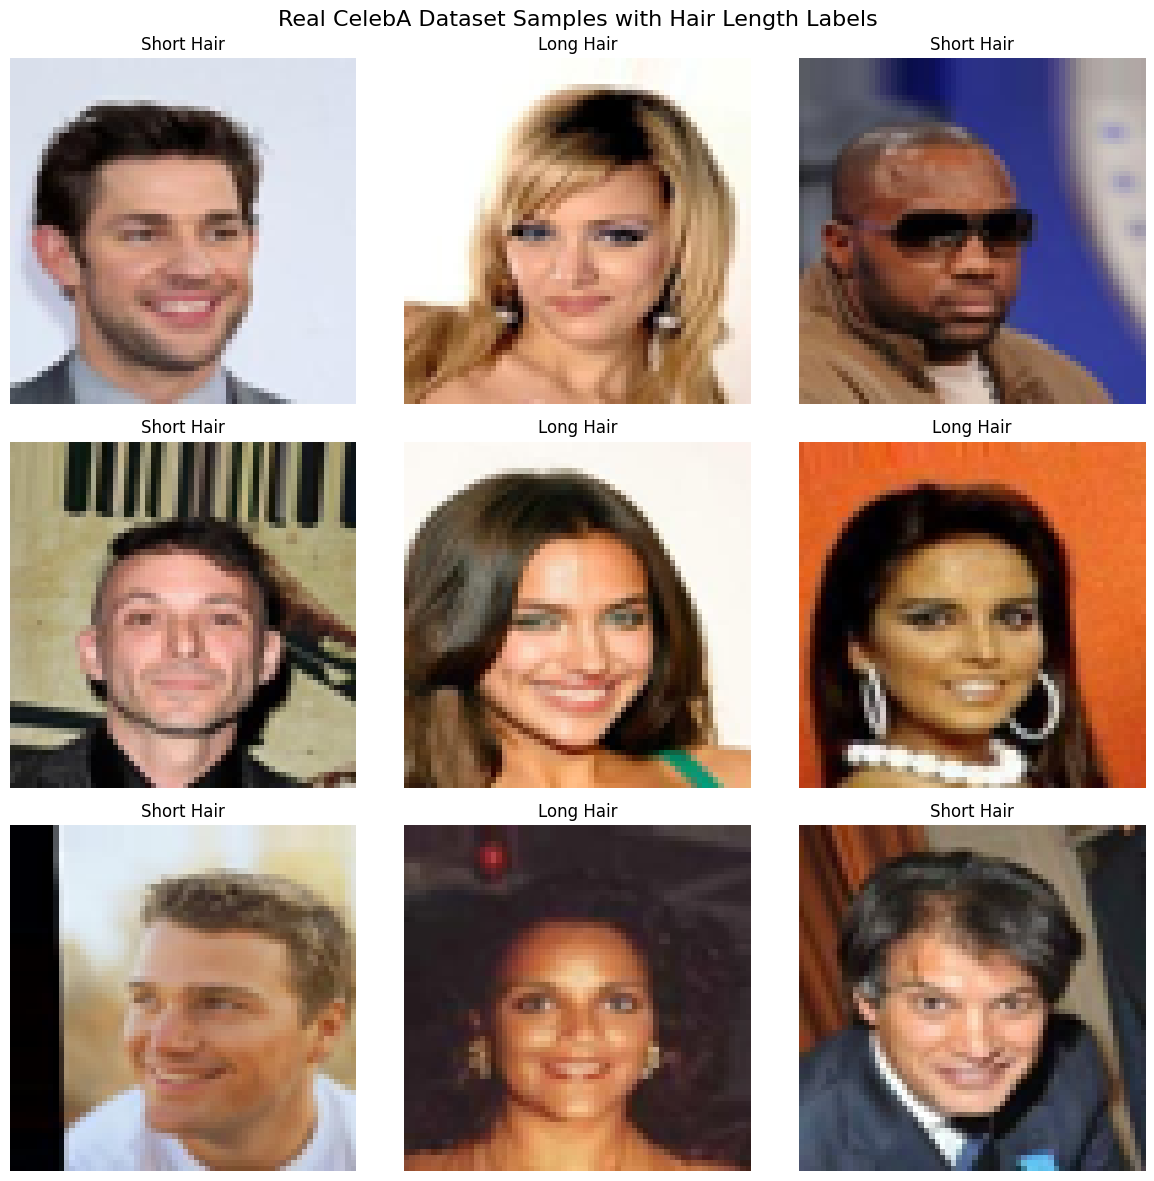

In [59]:


# Show sample of CelebA data
if X is not None:
    print("Sample of loaded CelebA data:")
    show_celeba_samples(X[:16], y[:16])

# Cell 9: Training Loop
def train_celeba_cgan(X, y, epochs):
    """Train CGAN on CelebA dataset"""

    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(1000).batch(config.BATCH_SIZE)

    # Fixed samples for visualization
    num_examples = 8
    test_noise = tf.random.normal([num_examples, config.LATENT_DIM])
    test_labels = tf.constant([0, 0, 0, 0, 1, 1, 1, 1])

    gen_losses = []
    disc_losses = []

    print("Starting CelebA CGAN training...")

    for epoch in range(epochs):
        epoch_gen_loss = []
        epoch_disc_loss = []

        for batch_idx, (image_batch, label_batch) in enumerate(dataset):
            gen_loss, disc_loss = train_step(image_batch, label_batch)
            epoch_gen_loss.append(gen_loss)
            epoch_disc_loss.append(disc_loss)

        avg_gen_loss = tf.reduce_mean(epoch_gen_loss)
        avg_disc_loss = tf.reduce_mean(epoch_disc_loss)

        gen_losses.append(avg_gen_loss.numpy())
        disc_losses.append(avg_disc_loss.numpy())

        # Show progress
        if epoch % 50 == 0:
            print(f'Epoch {epoch}: Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}')
            generate_and_save_images(generator, epoch, test_noise, test_labels)

        # Save checkpoints
        if epoch % 100 == 0 and epoch > 0:
            generator.save_weights(f'{config.CHECKPOINT_PATH}/celeba_gen_epoch_{epoch}.weights.h5')
            discriminator.save_weights(f'{config.CHECKPOINT_PATH}/celeba_disc_epoch_{epoch}.weights.h5')

    return gen_losses, disc_losses


Training CelebA CGAN...
Starting CelebA CGAN training...
Epoch 0: Gen Loss: 2.4884, Disc Loss: 1.1448


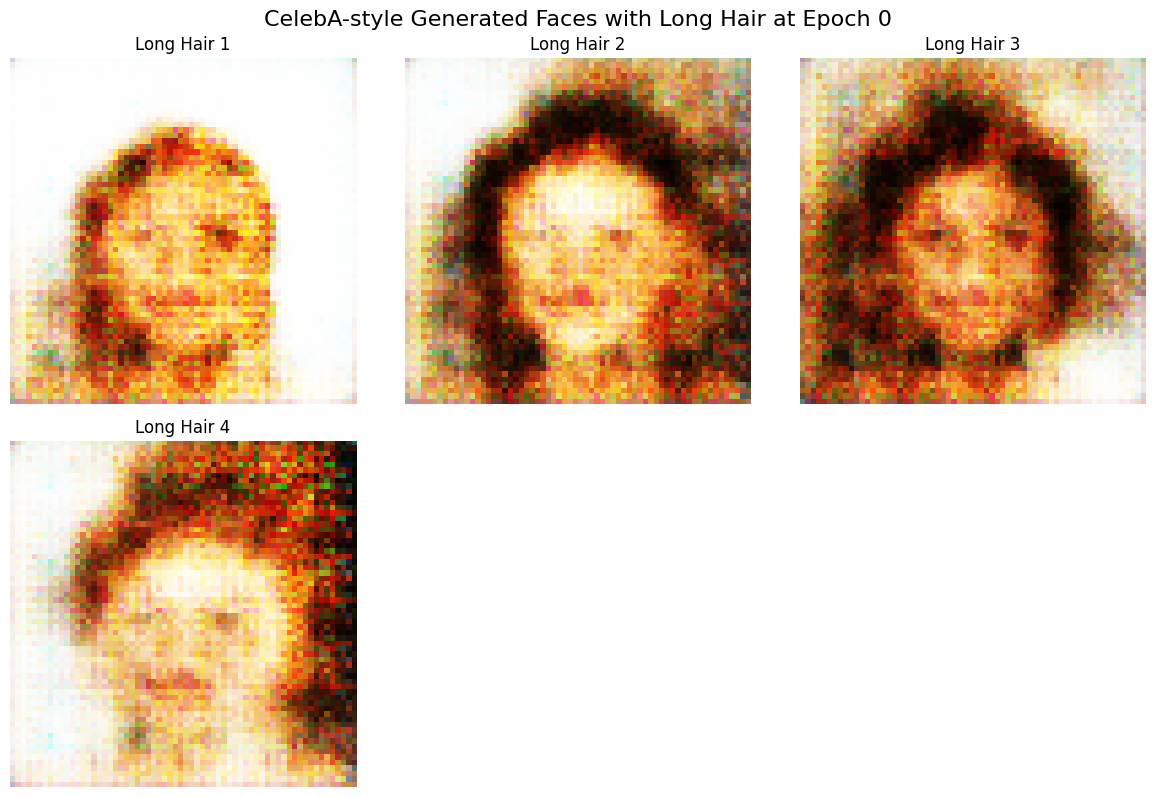

Epoch 50: Gen Loss: 2.1381, Disc Loss: 1.1416


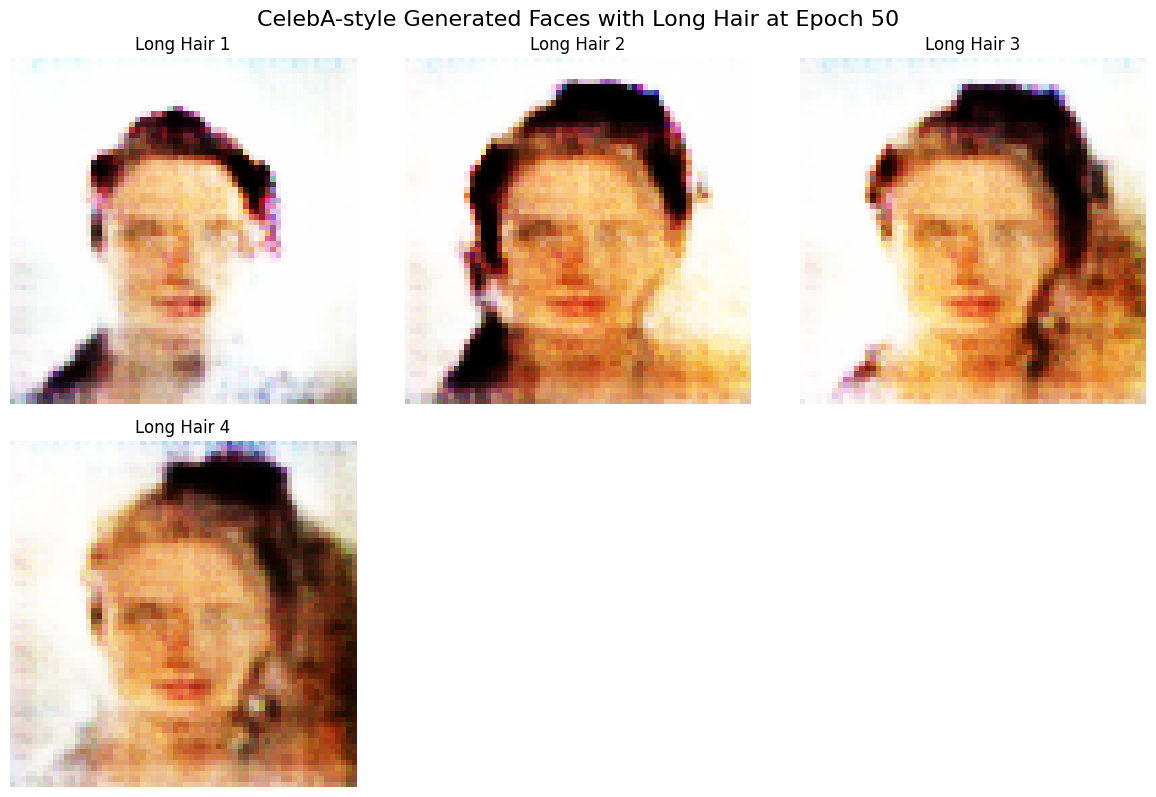

Epoch 100: Gen Loss: 2.5722, Disc Loss: 0.9550


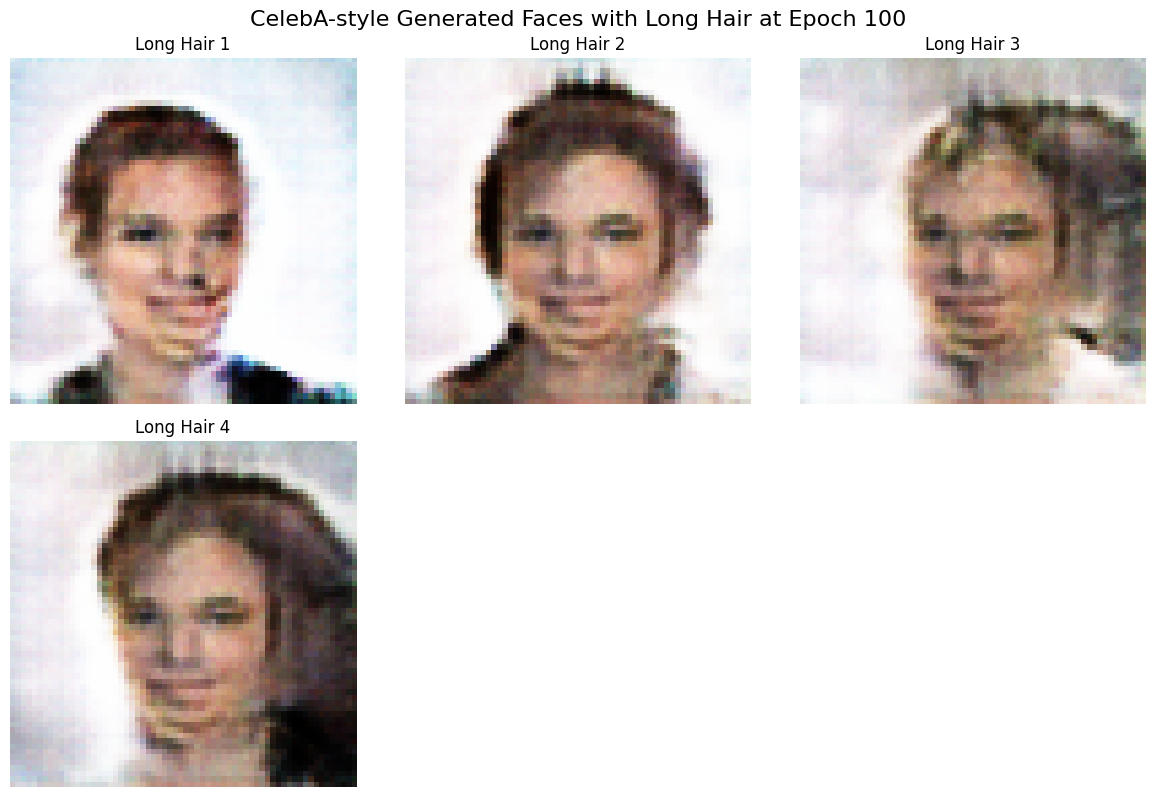

Epoch 150: Gen Loss: 2.4336, Disc Loss: 0.8663


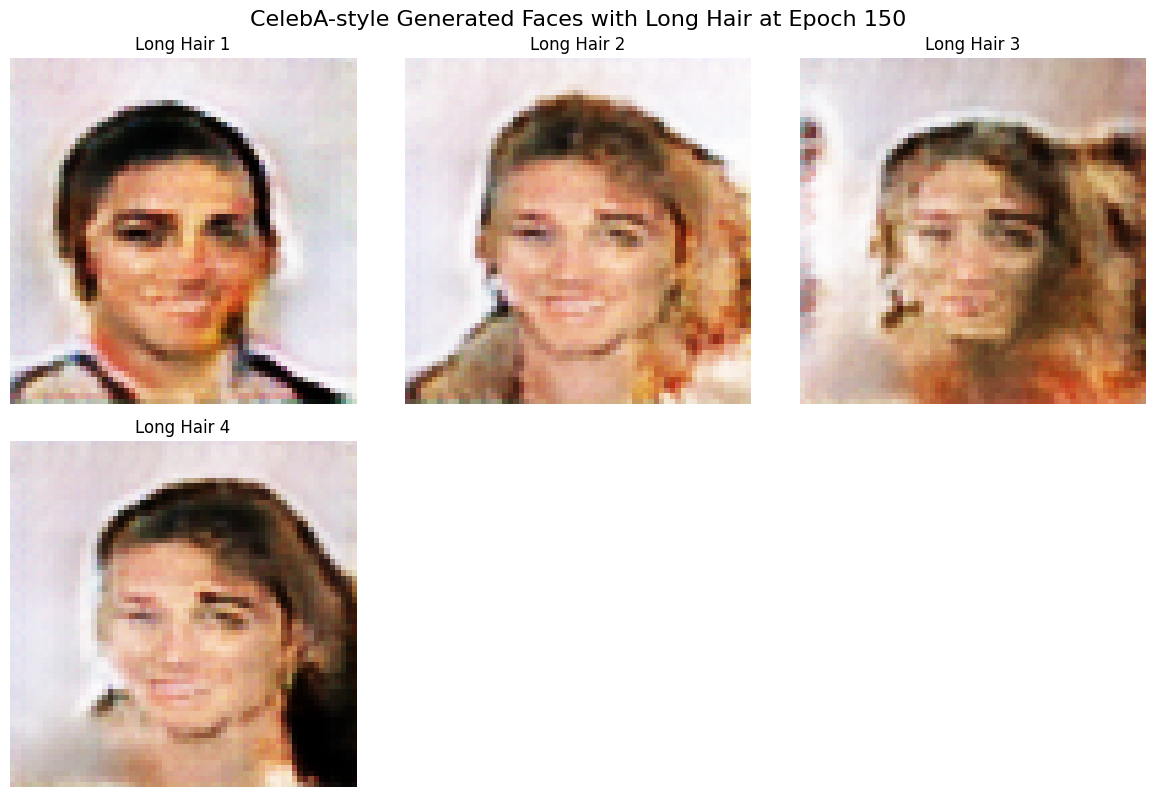

Epoch 200: Gen Loss: 2.3876, Disc Loss: 0.8535


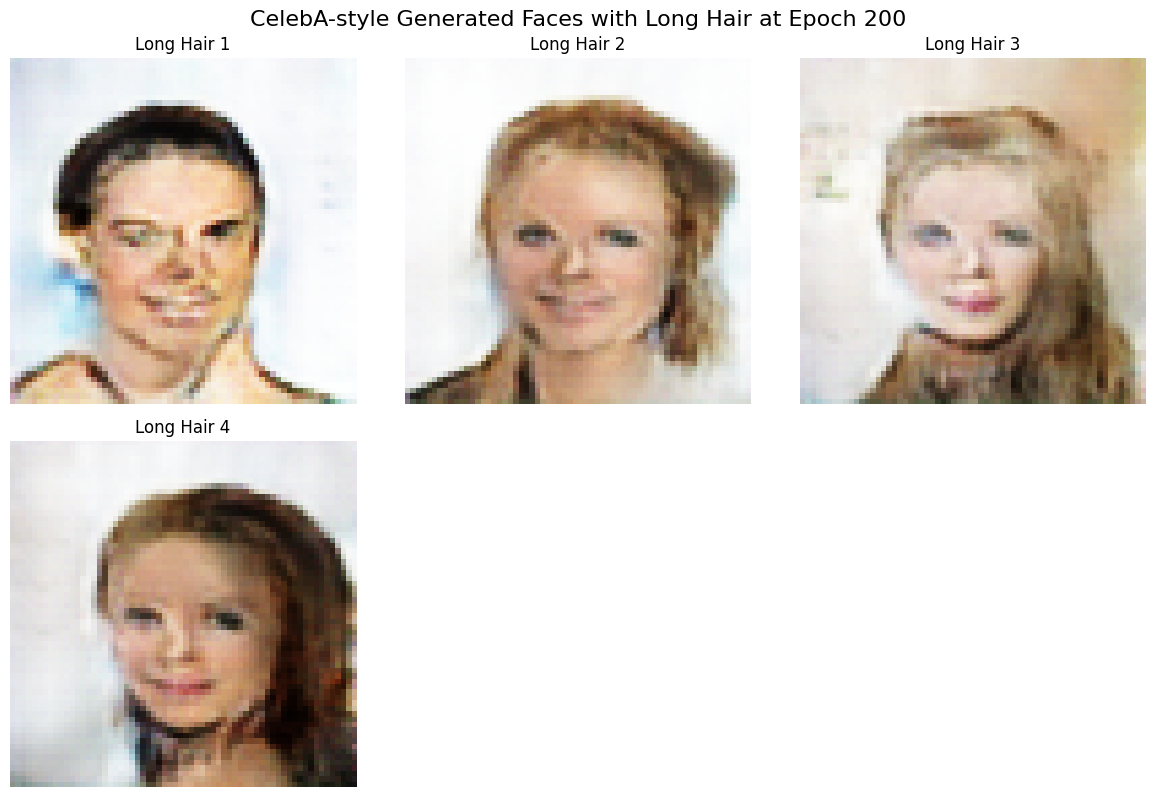

Epoch 250: Gen Loss: 2.6803, Disc Loss: 0.7762


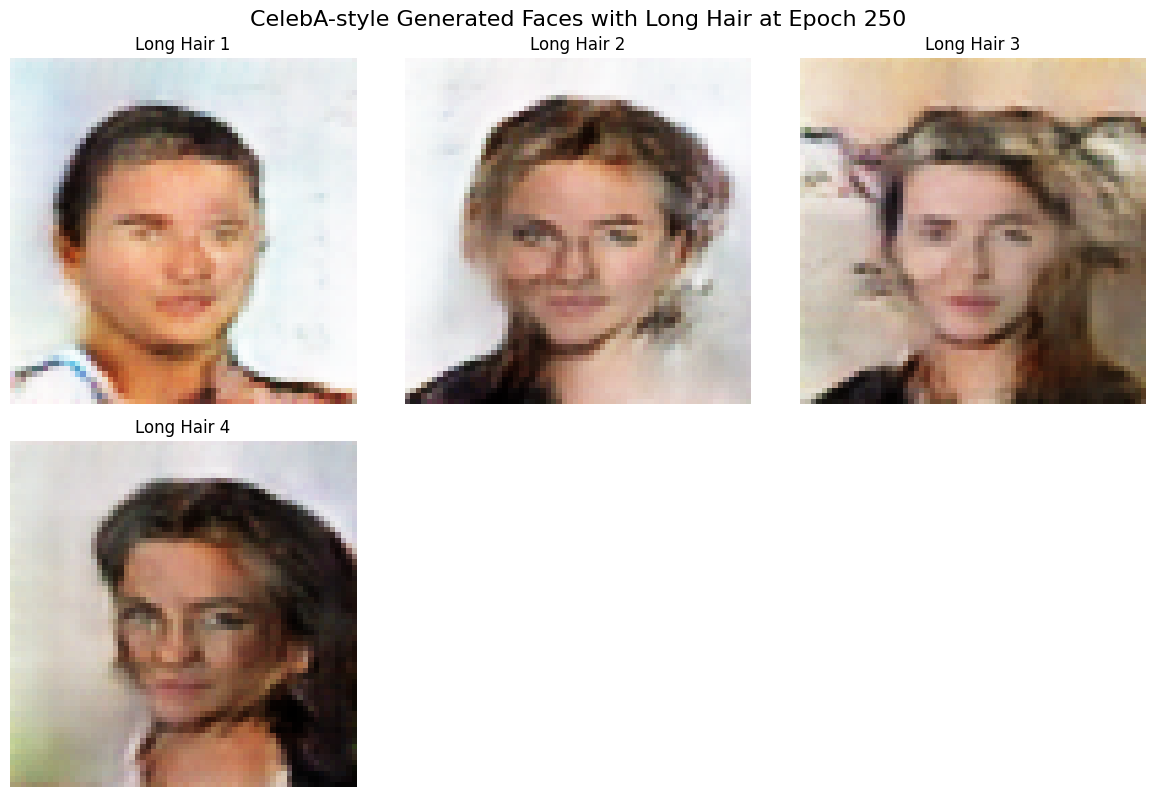

Epoch 300: Gen Loss: 2.8796, Disc Loss: 0.7079


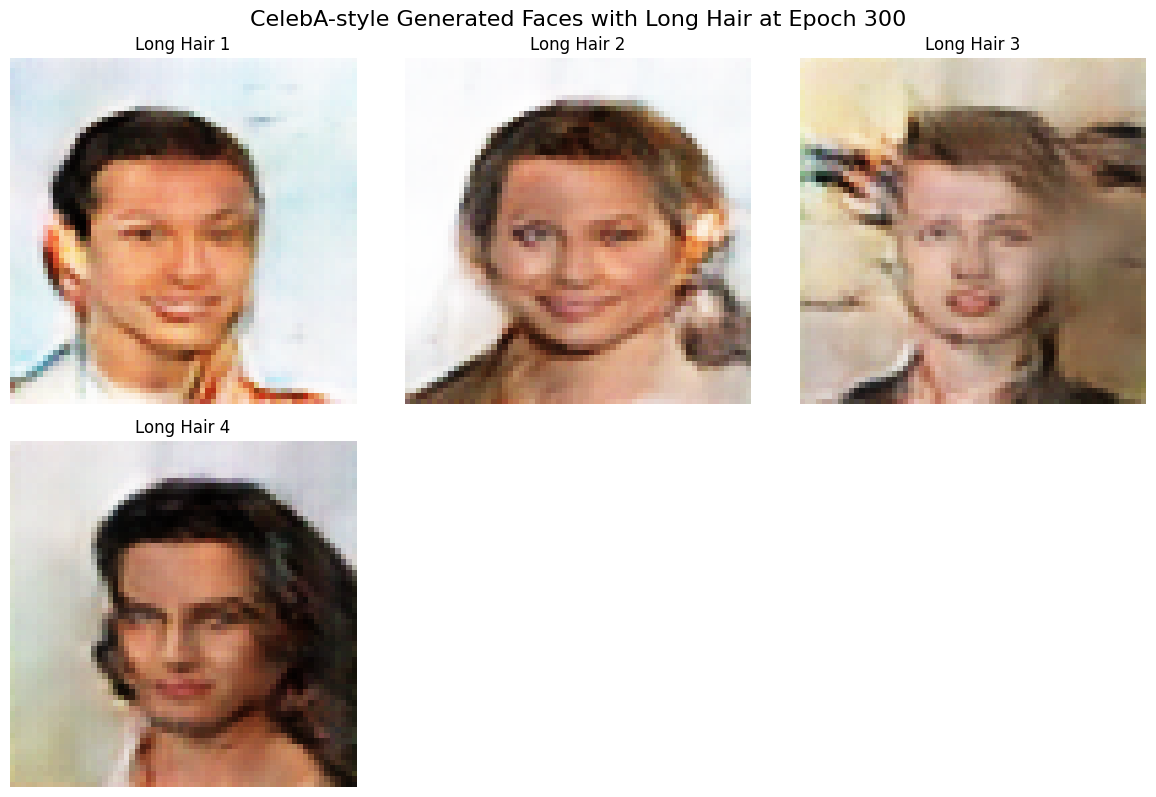

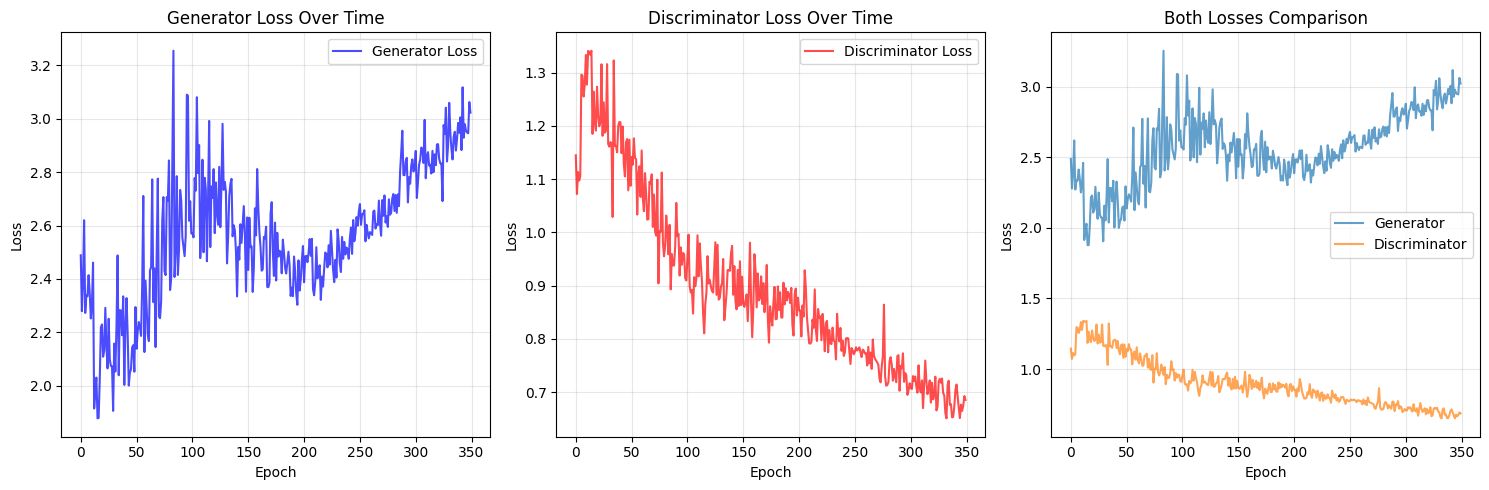

Generating final CelebA-style results...


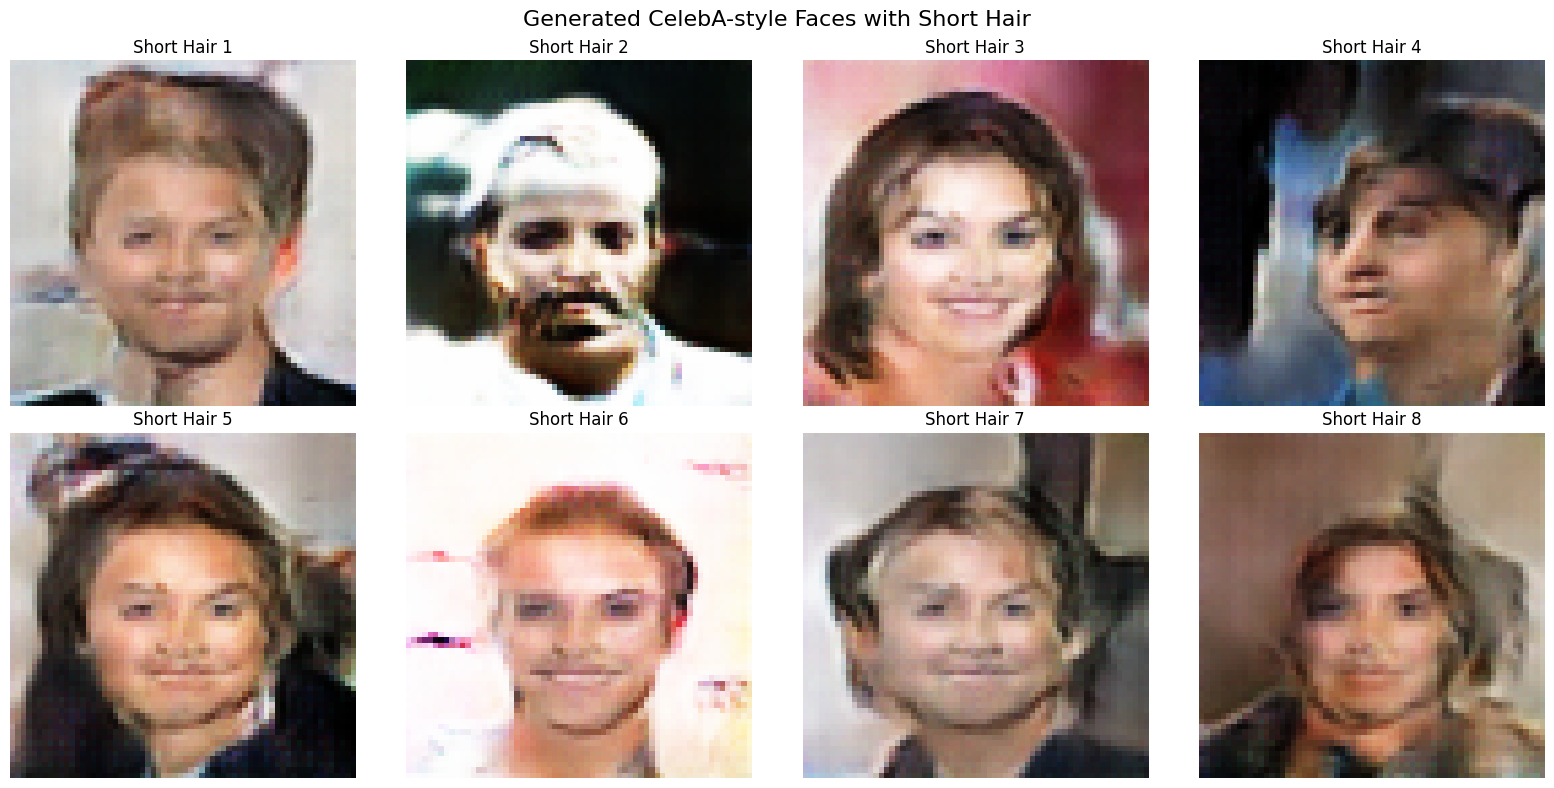

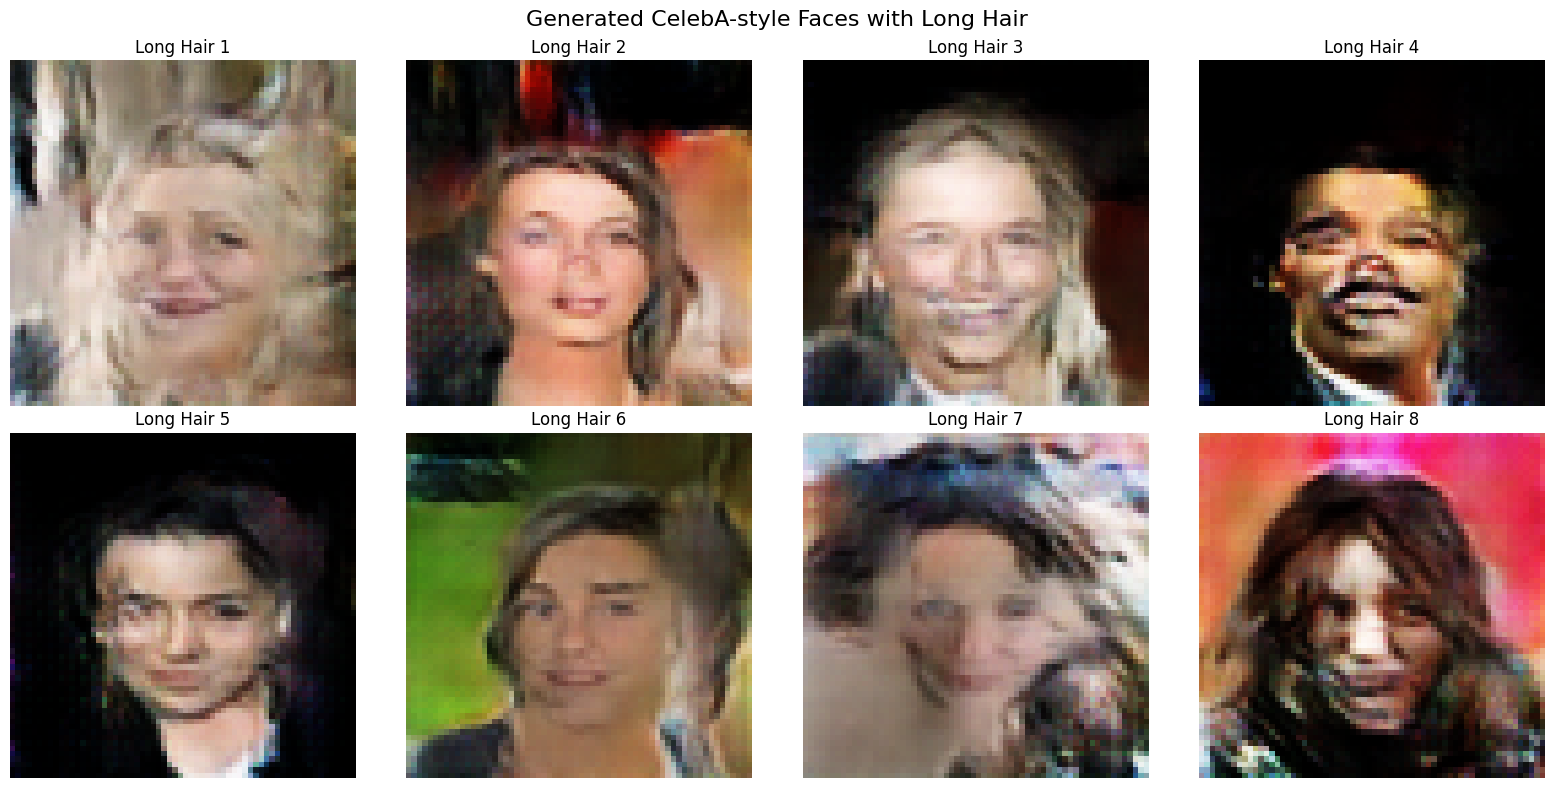

CelebA CGAN training completed!
Results saved in: output/


In [60]:

# Start training
if X is not None:
    print("Training CelebA CGAN...")
    gen_losses, disc_losses = train_celeba_cgan(X, y, config.EPOCHS)
else:
    print("Cannot start training without data. Please check your CelebA dataset path.")

# Cell 10: Results and Final Generation
if X is not None:
    def plot_training_losses(gen_losses, disc_losses):
        """Plot training losses"""
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(gen_losses, label='Generator Loss', color='blue', alpha=0.7)
        plt.title('Generator Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 3, 2)
        plt.plot(disc_losses, label='Discriminator Loss', color='red', alpha=0.7)
        plt.title('Discriminator Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 3, 3)
        plt.plot(gen_losses, label='Generator', alpha=0.7)
        plt.plot(disc_losses, label='Discriminator', alpha=0.7)
        plt.title('Both Losses Comparison')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def generate_celeba_faces(hair_type, num_images=8):
        """Generate CelebA-style faces with specific hair type"""
        label_value = 0 if hair_type.lower() == 'short' else 1
        labels = tf.constant([label_value] * num_images)
        noise = tf.random.normal([num_images, config.LATENT_DIM])

        generated_images = generator([noise, labels], training=False)
        generated_images = postprocess_images(generated_images)

        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        fig.suptitle(f'Generated CelebA-style Faces with {hair_type.title()} Hair', fontsize=16)

        for i in range(num_images):
            row = i // 4
            col = i % 4
            axes[row, col].imshow(generated_images[i])
            axes[row, col].set_title(f'{hair_type.title()} Hair {i+1}')
            axes[row, col].axis('off')

        plt.tight_layout()
        plt.savefig(f'{config.OUTPUT_PATH}/final_celeba_{hair_type}_hair.png', dpi=150, bbox_inches='tight')
        plt.show()

        return generated_images

    # Plot losses
    plot_training_losses(gen_losses, disc_losses)

    # Generate final results
    print("Generating final CelebA-style results...")
    short_hair_results = generate_celeba_faces('short', 8)
    long_hair_results = generate_celeba_faces('long', 8)

    # Save final models
    generator.save(f'{config.CHECKPOINT_PATH}/final_celeba_generator.keras')
    discriminator.save(f'{config.CHECKPOINT_PATH}/final_celeba_discriminator.keras')

    print("CelebA CGAN training completed!")
    print(f"Results saved in: {config.OUTPUT_PATH}")


In [61]:

# Cell 11: Interactive Generation Function
def generate_custom_faces(num_short=4, num_long=4):
    """Generate a mix of short and long hair faces"""
    if X is None:
        print("No trained model available. Please train the model first.")
        return

    total_images = num_short + num_long
    labels = [0] * num_short + [1] * num_long
    labels = tf.constant(labels)
    noise = tf.random.normal([total_images, config.LATENT_DIM])

    generated_images = generator([noise, labels], training=False)
    generated_images = postprocess_images(generated_images)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Custom Generated CelebA-style Faces', fontsize=16)

    for i in range(total_images):
        row = i // 4
        col = i % 4
        axes[row, col].imshow(generated_images[i])
        hair_type = "Short Hair" if i < num_short else "Long Hair"
        axes[row, col].set_title(f'{hair_type}')
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

    return generated_images

print("Setup complete! Update the CELEBA_PATH in the config and run the cells to train on your CelebA dataset.")

Setup complete! Update the CELEBA_PATH in the config and run the cells to train on your CelebA dataset.
